# Satellite melt rate distribution compared to MITgcm PIG melt 

Satellite data: 
- Adusumilli et al. (2020) paper: https://www.nature.com/articles/s41561-020-0616-z data: https://library.ucsd.edu/dc/collection/bb0175934d github: https://github.com/sioglaciology/ice_shelf_change
- Zinck et al. (2024), paper in review: https://www.researchsquare.com/article/rs-4806463/v1 data: https://data.4tu.nl/datasets/4e2ba9a9-7b1b-4837-b52d-036f8c876e67
- Bedmachine, Morlighem et al. (2020) data: https://nsidc.org/data/nsidc-0756/versions/3  paper: https://www.nature.com/articles/s41561-019-0510-8





In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import scipy.io as sio

rho_ow = 1028
rho_ice = 917

paired = sns.color_palette("Paired", 10)

from dask.distributed import Client
import cmocean as cm
import cmcrameri

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import pyproj as proj4
from pyproj import Transformer

import xarray as xr

In [2]:
# open polar projection used for all of these products
epsg4326 = proj4.CRS.from_epsg(4326) # Lat Lon WGS84
epsg3031 = proj4.CRS.from_epsg(3031) # SouthPolarStereo WGS84

#transformer = Transformer.from_crs(epsg4326, epsg3031)
transformer = Transformer.from_crs( epsg3031,epsg4326)


In [3]:
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32925 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32925/status,
Dashboard: /proxy/32925/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46849,Workers: 7
Dashboard: /proxy/32925/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:43753,Total threads: 4
Dashboard: /proxy/38761/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:34105,


In [4]:
# Adusumilli data (tools to open from https://github.com/sioglaciology/ice_shelf_change
folder = '/g/data/x77/cy8964/satellite-meltrate/Adusumilli/'
filename =folder+'ANT_iceshelf_melt_rates_CS2_2010-2018_v0.h5'
is_wb = h5py.File(filename,'r')
filename =folder+'ice_shelf_change/data/figure_1/max_thermal_forcing_200-800.h5'
tf = h5py.File(filename,'r')
x_wb = np.array(is_wb['/x'])
y_wb = np.array(is_wb['/y'])
wb = np.array(is_wb['/w_b'])


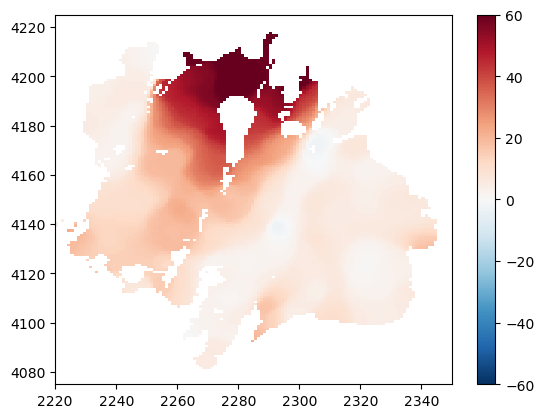

In [5]:
#rough PIG plot
plt.pcolormesh(wb,vmin=-60, vmax=60, cmap='RdBu_r')
plt.ylim(4075,4225)
plt.xlim(2220,2350)
plt.colorbar()

In [6]:
# open bedmachine data
BedMachine = xr.open_dataset('/g/data/x77/cy8964/satellite-meltrate/Adusumilli/BedMachineAntarctica-v3.nc')
BedMachine

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 178MB ...
    firn       (y, x) float32 711MB ...
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB ...
    errbed     (y, x) float32 711MB ...
    source     (y, x) int8 178MB ...
    dataid     (y, x) int8 178MB ...
    geoid      (y, x) int16 356MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

Text(0.5, 1.0, 'Adusumilli 2020 Pine Island Glacier melt rate')

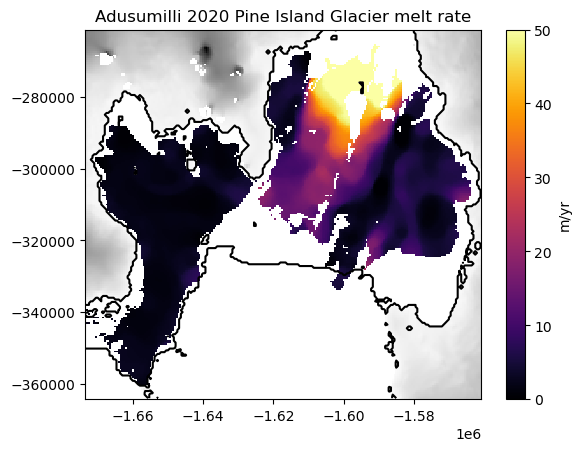

In [7]:
# plot together
wb_small = wb[4020:4226,2125:2351]
xs = x_wb[2125:2351]
ys = y_wb[4020:4226]

mask = BedMachine.mask.sel(x = slice(min(xs)[0],max(xs)[0]), y = slice(-261500,-364000))
surf = BedMachine.surface.sel(x = slice(min(xs)[0],max(xs)[0]), y = slice(-261500,-364000))

plt.pcolormesh(np.ravel(xs),np.ravel(ys),wb_small,vmin=0, vmax=50, cmap='inferno')
plt.colorbar(label = 'm/yr')

plt.contour(mask.x.values, mask.y.values,mask.values,levels = [2], colors = 'k')
plt.pcolormesh(mask.x.values, mask.y.values,surf.where(mask==2).values,cmap = 'Grays')


#plt.ylim(4020,4225)
#plt.xlim(2125,2350)
plt.title('Adusumilli 2020 Pine Island Glacier melt rate')

(225, 225)


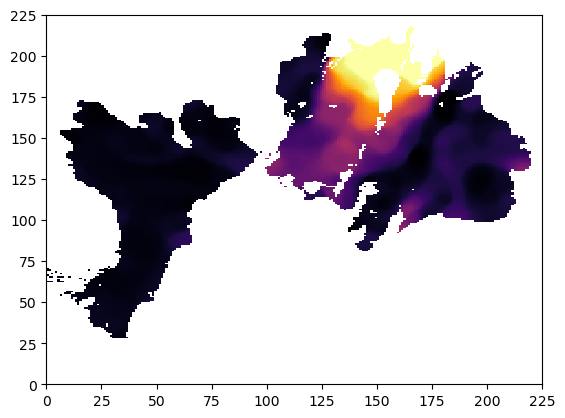

Text(0.5, 1.0, 'Distribution of melt rates, PIG (5m/yr bins)')

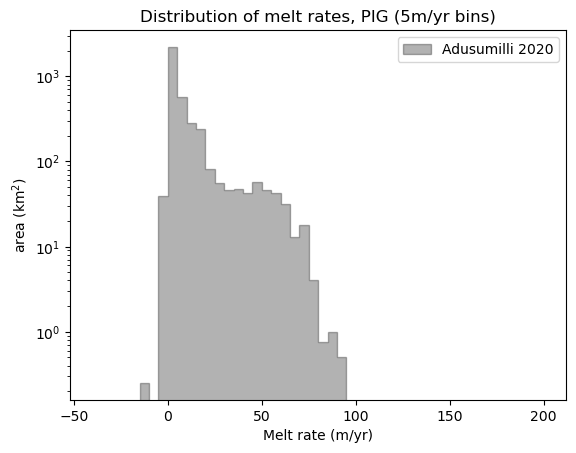

In [8]:
Wobs = wb[4000:4225,2125:2350,]
print(Wobs.shape)
xs = x_wb[2125:2351]
ys = y_wb[4000:4226] #diffs are 500m
area = 500*500/1e6*(np.ones(len(Wobs.flatten())))

plt.pcolormesh(Wobs,vmin=0, vmax=50, cmap='inferno')
plt.show()

fig, axes = plt.subplots()
colors = 'k'
axes.hist(Wobs.flatten(), np.linspace(-40,200,49), weights = area,
          histtype='step', color=colors, fill = True, alpha = 0.3,
          label='Adusumilli 2020')
#axes.set_ylim(1,80000)
axes.set_ylabel('area (km$^2$)')
axes.set_yscale('log')
axes.set_xlabel('Melt rate (m/yr)')
axes.legend()
axes.set_title('Distribution of melt rates, PIG (5m/yr bins)')


## open BURGEE data (Zinck 2024)

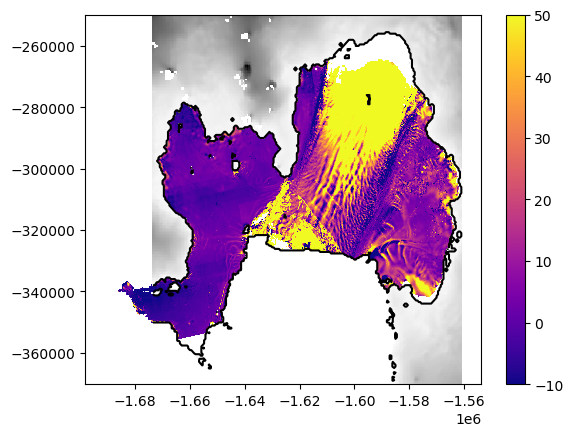

Text(0.5, 1.0, 'Distribution of melt rates, PIG (5m/yr bins)')

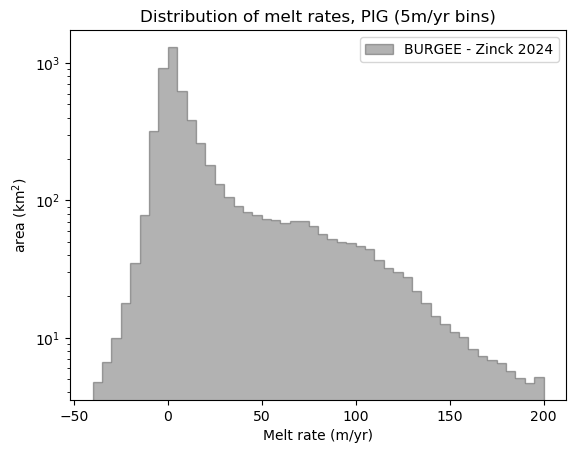

In [9]:
from osgeo import gdal   
  
dataset = gdal.Open('/g/data/x77/cy8964/satellite-meltrate/Adusumilli/PineIsland.tif')
ds = dataset
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

band1 = dataset.GetRasterBand(1)
b1 = dataset.ReadAsArray() 
img = b1
f = plt.figure() 
xs_arr = np.arange(img.shape[1])*(maxx-minx)/img.shape[1] + minx
ys_arr = np.arange(img.shape[0])*(maxy-miny)/img.shape[0] + miny

plt.pcolormesh(xs_arr,ys_arr,np.flip(img,axis = 0), cmap = 'plasma', vmin = -10, vmax = 50)
plt.colorbar()

mask = BedMachine.mask.sel(x = slice(min(xs)[0],max(xs)[0]), y = slice(-250000,-370000))
surf = BedMachine.surface.sel(x = slice(min(xs)[0],max(xs)[0]), y = slice(-250000,-370000))

plt.contour(mask.x.values, mask.y.values,mask.values,levels = [2], colors = 'k')
plt.pcolormesh(mask.x.values, mask.y.values,surf.where(mask==2).values,cmap = 'Grays')
plt.show() 

fig, axes = plt.subplots()
colors = 'k'
axes.hist(np.ravel(img), np.linspace(-40,200,49), weights = np.ones_like(np.ravel(img))*0.05**2,
          histtype='step', color=colors, fill = True, alpha = 0.3,
          label='BURGEE - Zinck 2024')
#axes.set_ylim(1,80000)
axes.set_ylabel('area (km$^2$)')
axes.set_yscale('log')
axes.set_xlabel('Melt rate (m/yr)')
axes.legend()
axes.set_title('Distribution of melt rates, PIG (5m/yr bins)')


# Plot MR histograms all together

/jobfs/127726252.gadi-pbs/ipykernel_3463820/4196947574.py:88: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle1 = patches.Patch(color=colors[0], alpha=0.5, linewidth=2, edgecolor = colors[0], label='HJ99-neutral (original)')
/jobfs/127726252.gadi-pbs/ipykernel_3463820/4196947574.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle2 = patches.Patch(color=colors[1], alpha=0.5, linewidth=2, edgecolor = colors[0], label='StratFeedback + tuned Cd')
/jobfs/127726252.gadi-pbs/ipykernel_3463820/4196947574.py:90: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle3 = patches.Patch(color=colors[2], alpha=0.5, linewidth=2, edgecolor = colors[0], label='StratFeedback only')
/jobfs/127726252.gadi-pbs/ipykernel_3463820/4196947574.py:91: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handl

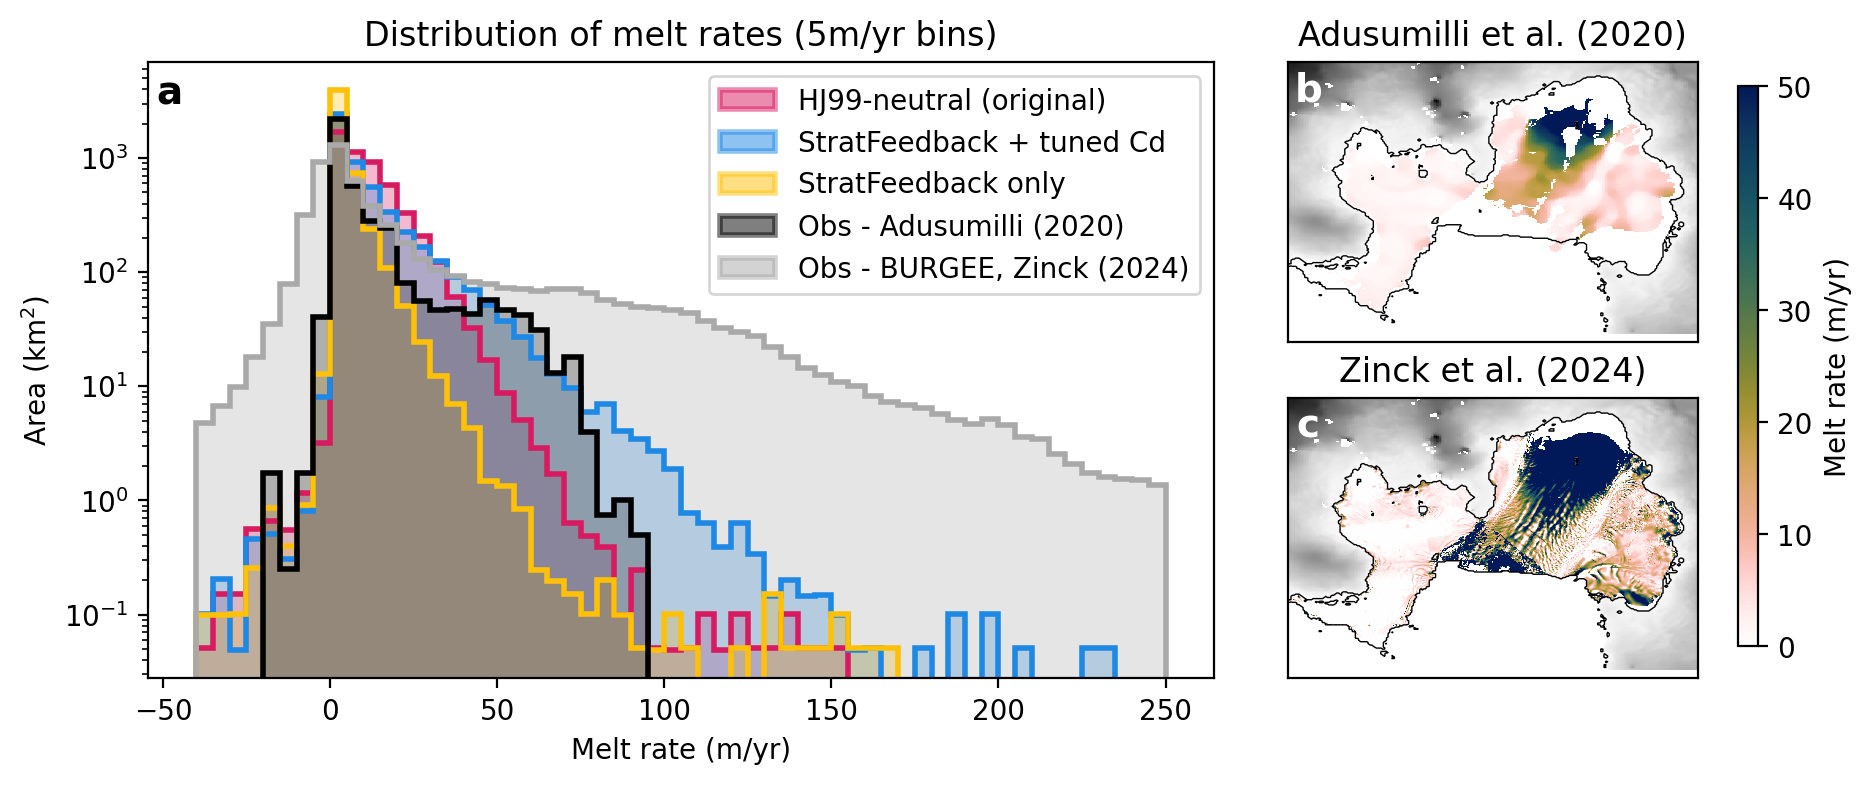

In [15]:
from MITgcmutils import mds
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import cmcrameri as cmc

fig = plt.figure(figsize = (10,4),dpi = 200)
gs = gridspec.GridSpec(2, 2, width_ratios=[2.6,1])
a0 = fig.add_subplot(gs[:,0])
a1 = fig.add_subplot(gs[0,1])
a2 = fig.add_subplot(gs[1,1])

a = [a0,a1,a2]

axes = a[0]
dir = '/scratch/x77/cy8964/gadi_short/cy8964/mitgcm/archive/'
names = ['original-run-R22_exe','run-R22-bigCd-20Aug','run-R22-20Aug',]
titles = ['Original HJ99',  'R22 + tuned Cd','R22 parameterisation']
#end = '/output001/'
# melt in kg/m^2/s to m/yr = multiply by #seconds per year, divide by rho_0
s_to_yr = 3600*24*365
rho0 = 1030
WHJ99 = np.zeros_like(mds.rdmds(dir+names[0]+'/output000/'+'SHICE_fwFlux', 43200))
for k in np.arange(2,5):
    for j in np.arange(10):
        time = np.arange(4320*(10*k+1),43201*(20*(k+1)),4320)[j]
        W = mds.rdmds(dir+names[0]+'/output00'+str(k)+'/'+'SHICE_fwFlux', time)#*(-s_to_yr)/rho0
        WHJ99 = WHJ99 + W
WHJ99 =WHJ99/30

WR22 = np.zeros_like(mds.rdmds(dir+names[2]+'/output000/'+'SHICE_fwFlux', 43200))
for k in np.arange(2,5):
    for j in np.arange(10):
        time = np.arange(4320*(10*k+1),43201*(20*(k+1)),4320)[j]
        W = mds.rdmds(dir+names[2]+'/output00'+str(k)+'/'+'SHICE_fwFlux', time)#*(-s_to_yr)/rho0
        WR22 = WR22 + W
WR22 =WR22/30


WR22cd = np.zeros_like(mds.rdmds(dir+names[1]+'/output000/'+'SHICE_fwFlux', 43200))
for k in np.arange(2,5):
    for j in np.arange(10):
        time = np.arange(4320*(10*k+1),43201*(20*(k+1)),4320)[j]
        W = mds.rdmds(dir+names[1]+'/output00'+str(k)+'/'+'SHICE_fwFlux', time)#*(-s_to_yr)/rho0
        WR22cd = WR22cd + W
WR22cd =WR22cd/30




WHJ99 = (np.where(WHJ99!=0, WHJ99,np.nan)*(-s_to_yr)/rho0).flatten()
WR22 = (np.where(WR22!=0, WR22,np.nan)*(-s_to_yr)/rho0).flatten()
WR22cd = (np.where(WR22cd!=0, WR22cd,np.nan)*(-s_to_yr)/rho0).flatten()

Area = mds.rdmds(dir+names[2]+'/output000/'+'RAC')/1e6
Area = Area.flatten()


axes.set_ylabel('Area (km$^2$)')
colors = ['#D81B60', '#1E88E5', '#FFC107','#000000','darkgrey']#'#9F53E9']
# axes.hist([WHJ99,WR22cd,WR22,Wobs.flatten()], np.linspace(-40,200,49), weights = [Area,Area,Area,area],
#           histtype='step', alpha = 0.4, edgecolors = colors,color=colors, fill = True,
#           label=['HJ99 original', 'R22 + tuned Cd', 'R22 strat. feedback','Adusumilli (2020)'])
axes.hist(WHJ99, np.linspace(-40,250,59), weights = Area,
          histtype='stepfilled', color=colors[0], alpha = 0.3, linewidth = 2)
axes.hist(WR22cd, np.linspace(-40,250,59), weights = Area,
          histtype='stepfilled',color=colors[1],alpha = 0.3, linewidth = 2)
axes.hist(WR22, np.linspace(-40,250,59), weights = Area,
          histtype='stepfilled',  color=colors[2],alpha = 0.3, linewidth = 2)
axes.hist(Wobs.flatten(), np.linspace(-40,250,59), weights = area,
          histtype='stepfilled',  color=colors[3], alpha = 0.3, linewidth = 2)
axes.hist(np.ravel(img), np.linspace(-40,250,59), weights = np.ones_like(np.ravel(img))*0.05**2,
          histtype='stepfilled', color=colors[4], alpha = 0.3, linewidth = 2)

axes.hist(WHJ99, np.linspace(-40,250,59), weights = Area,
          histtype='step', color=colors[0], linewidth = 2)
axes.hist(WR22cd, np.linspace(-40,250,59), weights = Area,
          histtype='step',color=colors[1], linewidth = 2)
axes.hist(WR22, np.linspace(-40,250,59), weights = Area,
          histtype='step', color=colors[2], linewidth = 2)
axes.hist(Wobs.flatten(), np.linspace(-40,250,59), weights = area,
          histtype='step', color=colors[3], linewidth = 2)
axes.hist(np.ravel(img), np.linspace(-40,250,59), weights = np.ones_like(np.ravel(img))*0.05**2,
          histtype='step', color=colors[4], linewidth = 2)
#axes.set_ylim(1,80000)
axes.set_yscale('log')
axes.set_xlabel('Melt rate (m/yr)')

handle1 = patches.Patch(color=colors[0], alpha=0.5, linewidth=2, edgecolor = colors[0], label='HJ99-neutral (original)')
handle2 = patches.Patch(color=colors[1], alpha=0.5, linewidth=2, edgecolor = colors[0], label='StratFeedback + tuned Cd')
handle3 = patches.Patch(color=colors[2], alpha=0.5, linewidth=2, edgecolor = colors[0], label='StratFeedback only')
handle4 = patches.Patch(color=colors[3], alpha=0.5, linewidth=2, edgecolor = colors[0], label='Obs - Adusumilli (2020)')
handle5 = patches.Patch(color=colors[4], alpha=0.5, linewidth=2, edgecolor = colors[0], label='Obs - BURGEE, Zinck (2024)')

axes.legend(handles=[handle1,handle2,handle3,handle4,handle5])
axes.set_title('Distribution of melt rates (5m/yr bins)')

Wobs = wb[4000:4250,2100:2360,]
xs = x_wb[2100:2360]
ys = y_wb[4000:4250] #diffs are 500m

wb_small = Wobs
area = 500*500/1e6*(np.ones(len(Wobs.flatten())))

mask = BedMachine.mask.sel(x = slice(min(xs)[0],max(xs)[0]), y = slice(-250000,-370000))
surf = BedMachine.surface.sel(x = slice(min(xs)[0],max(xs)[0]), y = slice(-250000,-370000))

b = a[1].pcolormesh(np.ravel(xs)/1e3,np.ravel(ys)/1e3,wb_small,vmin=0, vmax=50, cmap='cmc.batlowW_r')
#plt.colorbar(b, label = 'Melt rate (m/yr)')

a[1].contour(mask.x.values/1e3, mask.y.values/1e3,mask.values,levels = [2], colors = 'k',linewidths = 0.5)
a[1].pcolormesh(mask.x.values/1e3, mask.y.values/1e3,surf.where(mask==2).values,cmap = 'Grays')


#plt.ylim(4020,4225)
#plt.xlim(2125,2350)
#b = a[1].contourf(0.5*np.arange(len(Wobs[0,:])),0.5*np.arange(len(Wobs[:,0])),
#                                            Wobs,levels = np.linspace(0,50,51), cmap='cmc.batlowW_r',extend = 'both')
#plt.colorbar(b,label = 'Melt rate (m/yr)')
a[1].set_title('Adusumilli et al. (2020)')
a[1].set_ylabel('km')
a[1].set_xlabel('km')

a[1].set_xlim(min(xs)[0]/1e3,max(xs)[0]/1e3)
a[1].set_ylim(min(ys)[0]/1e3,max(ys)[0]/1e3)

xs_arr = np.arange(img.shape[1])*(maxx-minx)/img.shape[1] + minx
ys_arr = np.arange(img.shape[0])*(maxy-miny)/img.shape[0] + miny

b2 = a[2].pcolormesh(xs_arr/1e3,ys_arr/1e3,np.flip(img,axis = 0), cmap = 'cmc.batlowW_r', vmin = 0, vmax = 50)
cax = plt.axes([0.92,0.15,0.01,0.7])
plt.colorbar(b2, cax = cax,label = 'Melt rate (m/yr)')

a[2].contour(mask.x.values/1e3, mask.y.values/1e3,mask.values,levels = [2], colors = 'k',linewidths = 0.5)
a[2].pcolormesh(mask.x.values/1e3, mask.y.values/1e3,surf.where(mask==2).values,cmap = 'Grays')

a[2].set_title('Zinck et al. (2024)')
a[2].set_ylabel('km')
a[2].set_xlabel('km')
a[2].set_xlim(min(xs)[0]/1e3,max(xs)[0]/1e3)
a[2].set_ylim(min(ys)[0]/1e3,max(ys)[0]/1e3)

a[1].set_xticklabels('')
a[1].set_xlabel('')
a[1].set_xticks([])

a[2].set_xticklabels('')
a[2].set_xlabel('')
a[2].set_xticks([])

a[1].set_yticklabels('')
a[1].set_ylabel('')
a[1].set_yticks([])

a[2].set_yticklabels('')
a[2].set_ylabel('')
a[2].set_yticks([])



axes.text(0.02,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes.transAxes, fontsize = 14)
a[1].text(0.05,0.9,'b',horizontalalignment='center', fontweight='bold',color = 'w',
     verticalalignment='center',transform=a[1].transAxes, fontsize = 14)
a[2].text(0.05,0.9,'c',horizontalalignment='center', fontweight='bold',color = 'w',
     verticalalignment='center',transform=a[2].transAxes, fontsize = 14)

fig.subplots_adjust(wspace = 0.1)